## Práctica Final
### Machine Learning

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tabulate import tabulate
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split
import matplotlib.cm as cm
from matplotlib.pyplot import figure
from sklearn.neighbors import NearestNeighbors



random_num = 100
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/airbnb-listings-extract.csv', sep = ';')

### Análisis Descriptivo

El primer paso para resolver esta práctica será realizar un pequeño análisis descriptivo de la base de datos junto con la limpieza de la misma. Es una base de datos que no ha sido limpiada previamente por lo que nos centraremos en eliminar todas aquellas columnas que no nos aporten información necesaria, tratar los valores nulos, tratar la variable objetivo y cambiar el tipo de variables cuando sea necesario. 

Para mayor facilidad, cambiaremos el nombre de las columnas para sustituir el espacio por '_' 

In [ ]:
data.columns = data.columns.str.replace(' ', '_')

Uno de los primeros pasos será quedarnos solo con las viviendas de Madrid. Esto lo hacemos porque la gran mayoría de viviendas están en este mercado y la localización por ciudades va a sesgar el precio en gran medida cuando nos queremos centrar en la calidad principalmente. 

In [ ]:
data = data.loc[data.Market == 'Madrid']
data = data.drop(columns ='Market')

In [ ]:
data.shape

(13274, 88)

A continuación analizaremos la **variable objetivo**, el precio:

In [ ]:
print('Total de datos missing en la variable Precio:', data['Price'].isnull().sum())

Total de datos missing en la variable Precio: 9


Como solo hay 9 observaciones cuyo precio es desconocido optaremos por eliminarlas. No las sustituiremos pues es un número muy pequeño de NAs no significativo en la muestra final:

In [ ]:
data = data[data['Price'].notna()]

In [ ]:
data['Price'].describe()

count    13265.000000
mean        67.430833
std         61.784819
min          9.000000
25%         30.000000
50%         52.000000
75%         80.000000
max        875.000000
Name: Price, dtype: float64

Como podemos observar, el precio mínimo por noche está en 9€ y el máximo en 875€. La media y la mediana están algo alejadas la una de la otra (67 y 52) esto nos indica que la muestra probablemente presenta algunos valores atípicos con precios excesivamente altos. 

A continuación analizaremos los datos **missing**:

In [ ]:
pd.set_option('display.max_rows', None)

pd.DataFrame({'Number_Missing': data.isna().sum(),
              'Percent_Missing': round(data.isnull().sum() * 100 / len(data),2),
              'Type': data.dtypes}).sort_values(by = "Percent_Missing", ascending=False)

,Number_Missing,Percent_Missing,Type
Jurisdiction_Names,13265,100.00,object
Host_Acceptance_Rate,13265,100.00,object
Has_Availability,13265,100.00,object
License,13016,98.12,object
Square_Feet,12744,96.07,float64
Monthly_Price,9945,74.97,float64
Weekly_Price,9902,74.65,float64
Notes,8272,62.36,object
Security_Deposit,7635,57.56,float64
Interaction,5793,43.67,object


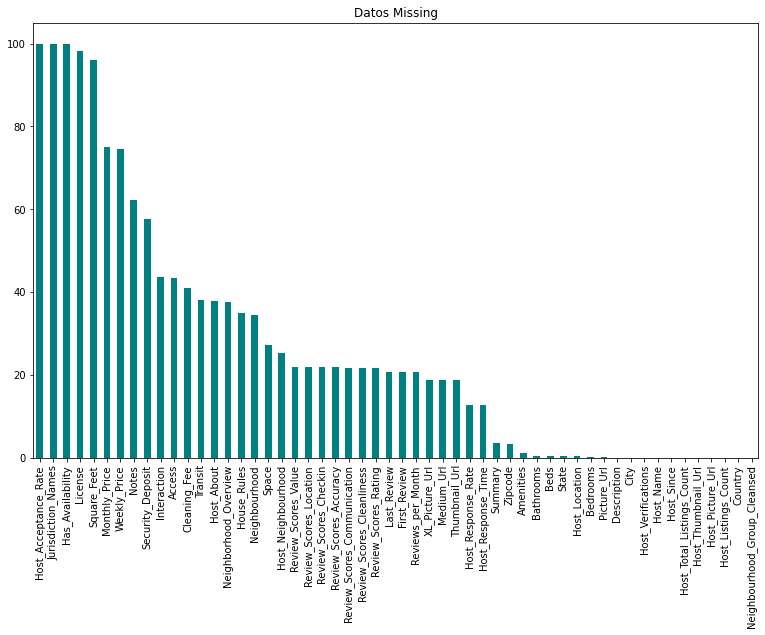

In [ ]:
missing = data.isnull().mean()*100
figure(figsize = (13,8))
datos_missing =  missing[missing > 0].sort_values(ascending=False)
datos_missing.plot.bar(title = 'Datos Missing', color='teal')


En el gráfico superior se puede observar que todos los datos de las variables Jurisdiction_Names, Has_Availability y Host_Acceptance_Rate contienen son nulos. Por otro lado, las variables License y Square_Feet también contienen un número significativo de datos missing. Estas columnas, por tanto, deberán ser eliminadas ya que no aportan nada en nuestro análisis. También nos desharemos de otras variables que explicaremos más adelante.

En primer lugar eliminaré las siguientes variables:


        ⁃ Aquellas columnas que posean más de un 90% de datos missing las eliminaremos.
        ⁃ Aquellas columnas que no nos aportan ninguna información por ser únicas para cada observación.
        ⁃ Eliminaremos también aquellas variables que toman solo un valor para todas las observaciones. 
        ⁃ La variable geolocalización pues es una mezcla de las variables latitud y longitud. 
        ⁃ La variable Host_Name pues nos quedaremos solo con Host_ID
        ⁃ Las variables Neighbourhood y Neighbourhood_Group_Cleansed y matendremos Neighbourhood_Cleansed
        ⁃ Zipcode se descarta ya que toda la informcion posicional esta entre nombre del barrio, longitud y latitud

In [ ]:
data = data.drop(columns = ['ID', 'Listing_Url', 'Geolocation','Scrape_ID', 'Name' , 'Experiences_Offered', 'Host_Acceptance_Rate', 
                            'Square_Feet', 'License', 'Jurisdiction_Names', 'Has_Availability', 'Last_Scraped', 'Host_Name', 'City',
                            'Neighbourhood', 'Neighbourhood_Group_Cleansed', 'State', 'Country_Code', 'Country', "Zipcode" ])


A continuación pasaremos a examinar las columnas que tienen más datos missing para tratar de encontrar una razón y sustituir los NAs por el valor más correcto. En primer lugar observamos que tanto las columnas de precio semanal como la de precio mensual tienen un 75% de datos missing. 

Una primera hipótesis es que aquellos que tienen valores de precio semanal y mensual es porque ofrecen un descuento por estancias largas. Si esto es cierto podemos asumir que el resto no ofrecen ese descuento y sustituir los NAs por el precio multiplicado por 7 y 30 respectivamente. 

In [ ]:
p = data[['Price', 'Weekly_Price', 'Monthly_Price']].dropna()
p['Weekly_Price'] = p['Weekly_Price']/7
p['Monthly_Price'] = p['Monthly_Price']/30
p['Weekly_Discount'] = ((p['Weekly_Price'] - p['Price']) <= 0)
p['Monthly_Discount'] = ((p['Monthly_Price'] - p['Price']) <= 0)

In [ ]:
monthly_discount= p['Monthly_Discount'].value_counts()
weekly_discount =p['Weekly_Discount'].value_counts()

In [ ]:
discount = pd.DataFrame({'Monthly Discount': monthly_discount, 
                        'Weekly Discount': weekly_discount})
discount

,Monthly Discount,Weekly Discount
True,2635,2146
False,167,656


Como podemos observar, para la gran mayoría, especialmente los de más larga estancia, la hipótesis del descuento es verdadera. Por tanto, sustituiremos el valor de estos NA por el precio diario multiplicado por 7 para el precio semanal y por 30 para el precio mensual. 

Ademas, para que estos precios semanales y mensuales no sesgen los algoritmos, computaremos el descuento semanal y mensual como porcentage y descartaremos las variables de precio mensual y semanal

In [ ]:
data['Weekly_Price'] = data['Weekly_Price'].fillna(data['Price']*7)
data['Monthly_Price'] = data['Monthly_Price'].fillna(data['Price']*30)

In [ ]:
data['Weekly_Dsicount'] = ((data['Price']*7)-data['Weekly_Price'])/(data['Price']*7)
data['Monthly_Dsicount'] = ((data['Price']*30)-data['Monthly_Price'])/(data['Price']*30)

In [ ]:
data = data.drop(columns = ['Weekly_Price', 'Monthly_Price'])


1.   La variable Notas representa aquellos comentarios adicionales que el arrendador quiere comunicar al inquilino. En caso de valor NA supondremos que viene de que el arrendador no tenga nada que añadir y sustituiremos estos valores por 'Nada'. Lo mismo haremos con las variables Summary y Description que deberían resumir el espacio.

2.   Para las variables 'Space', 'Neighborhood_Overview', 'Transit', 'Access', 'Interaction', 'Host_Location', 'Host_Neighbourhood', 'Amenities', 'Host_About', 'Host_Verifications' y 'House_Rules' que deberían aportar información adicional sobre el apartamento y el arrendador cuando exista NA lo sustituiremos por 'Sin informacion'. 

3.   Para las variables de imagen sustituiremos los NAs por 'Sin imagen' 
Para todas las variables de fecha las sustituiremos por una fecha muy antigua. Para las variables de review con missing por un número muy alejado (500). 

4.   En el caso del depósito y el el servicio de limpieza, entenderemos que si no hay valor es porque no se requiere pagar uno y sustituiremos el valor NA por 0.

5.   En el caso de Zipcode nos debería indicar el barrio en el que está localizado cada bivienda, como no hay manera de conocer qué valor le correspondería a los missing los sustituiremos todos por '0000'.

6.   Para las variables Host_Response_Time y Host_Response_Rate como no podemos saber si los Missing vienen de un tiempo de respuesta excesivamente elevado o bajo les daremos un valor muy diferente a los que hay en el dataFrame para diferenciarlos en el análisis. Lo mismo haremos para el caso de las variables baños, habitaciones y camas.

In [ ]:
data['Notes'] = data['Notes'].fillna('Nada')
data['Summary'] = data['Summary'].fillna('Nada')
data['Description'] = data['Description'].fillna('Nada')

data['Space'] = data['Space'].fillna('Sin Informacion')
data['Neighborhood_Overview'] = data['Neighborhood_Overview'].fillna('Sin Informacion')
data['House_Rules'] = data['House_Rules'].fillna('Sin Informacion')
data['Interaction'] = data['Interaction'].fillna('Sin Informacion')
data['Transit'] = data['Transit'].fillna('Sin Informacion')
data['Access'] = data['Access'].fillna('Sin Informacion')
data['Host_About'] = data['Host_About'].fillna('Sin Informacion')
data['Host_Location'] = data['Host_Location'].fillna('Sin Informacion')
data['Host_Neighbourhood'] = data['Host_Neighbourhood'].fillna('Sin Informacion')
data['Amenities'] = data['Amenities'].fillna('Sin Informacion')
data['Host_Verifications'] = data['Host_Verifications'].fillna('Sin Informacion')

data['Thumbnail_Url'] = data['Thumbnail_Url'].fillna('Sin Imagen')
data['Medium_Url'] = data['Medium_Url'].fillna('Sin Imagen')
data['Picture_Url'] = data['Picture_Url'].fillna('Sin Imagen')
data['XL_Picture_Url'] = data['XL_Picture_Url'].fillna('Sin Imagen')
data['Host_Thumbnail_Url'] = data['Host_Thumbnail_Url'].fillna('Sin Imagen')
data['Host_Picture_Url'] = data['Host_Picture_Url'].fillna('Sin Imagen')

data['First_Review'] = data['First_Review'].fillna('1900-01-01')
data['Last_Review'] = data['Last_Review'].fillna('1900-01-01')
data['Host_Since'] = data['Host_Since'].fillna('1900-01-01')
data['Review_Scores_Rating'] = data['Review_Scores_Rating'].fillna(500)
data['Review_Scores_Accuracy'] = data['Review_Scores_Accuracy'].fillna(500)
data['Review_Scores_Cleanliness'] = data['Review_Scores_Cleanliness'].fillna(500)
data['Review_Scores_Checkin'] = data['Review_Scores_Checkin'].fillna(500)
data['Review_Scores_Communication'] = data['Review_Scores_Communication'].fillna(500)
data['Review_Scores_Location'] = data['Review_Scores_Location'].fillna(500)
data['Review_Scores_Value'] = data['Review_Scores_Value'].fillna(500)
data['Reviews_per_Month'] = data['Reviews_per_Month'].fillna(500)

data['Security_Deposit'] = data['Security_Deposit'].fillna(0)
data['Cleaning_Fee'] = data['Cleaning_Fee'].fillna(0)

data['Host_Response_Time'] = data['Host_Response_Time'].fillna(99)
data['Host_Response_Rate'] = data['Host_Response_Rate'].fillna(0)

data['Bathrooms'] = data['Bathrooms'].fillna(99)
data['Bedrooms'] = data['Bedrooms'].fillna(99)
data['Beds'] = data['Beds'].fillna(99)

data = data[data['Host_Listings_Count'].notna()]

A continuación nos centraremos en cambiar los tipos confundidos.

In [ ]:
data_types=pd.DataFrame({'Tipo de Variable': data.select_dtypes(exclude=["float64","int64"]).dtypes})
data_types

,Tipo de Variable
Summary,object
Space,object
Description,object
Neighborhood_Overview,object
Notes,object
Transit,object
Access,object
Interaction,object
House_Rules,object
Thumbnail_Url,object


Todas aquellas variables que sean de tipo fecha las pasaremos a número de días hasta la actualidad.

Por otro lado, la variable Host_Response se puede transformar a ordinal numérica.  

In [ ]:
data['First_Review'] = (pd.to_datetime("2022-05-22") - pd.to_datetime(data['First_Review'])).dt.days
data['Last_Review'] = (pd.to_datetime("2022-05-22") - pd.to_datetime(data['Last_Review'])).dt.days
data['Calendar_last_Scraped'] = (pd.to_datetime("2022-05-22") - pd.to_datetime(data['Calendar_last_Scraped'])).dt.days
data['Host_Since'] = (pd.to_datetime("2022-05-22") - pd.to_datetime(data['Host_Since'])).dt.days


In [ ]:
Host_response = {"Host_Response_Time": {"within an hour": 1, "within a few hours": 2, "within a day": 3, "a few days or more": 4, 99:99}}
data=data.replace(Host_response)

Las variables Host_Neighbourhood y Neighbourhood_Cleansed tienen demasiados tipos distintos de observaciones por lo que la transformaremos de modo que si el tipo no se repite un número determinado de veces sea sustituido por "otros". 

In [ ]:
data.loc[data.groupby('Host_Neighbourhood').Host_Neighbourhood.transform('count').lt(15), 'Host_Neighbourhood'] = "otros"    
data.loc[data.groupby('Neighbourhood_Cleansed').Neighbourhood_Cleansed.transform('count').lt(10), 'Neighbourhood_Cleansed'] = "otros"    

#ISA
La variable calendar_updated es un string pero sería de mayor uso si fuera una variable numérica. Para pasarla a numérica lo haremos en meses, para ello quitaremos la frase de ' months ago' cuando la tenga y en el caso de que sea weeks ago dividiremos el número entre 4, en el caso de que sea Days ago dividiremos el número entre 30. 

En las dos figuras superirores podemos observar que las zonas con más oferta de Airbnbs en Madrid son Embajadores, Universidad y Palacio.

In [ ]:
data = data.drop(columns = ['Calendar_Updated'])

data['Calendar_Updated_months'] = data['Calendar_Updated'].str.replace(' months ago', '' )
data['Calendar_Updated_weeks'] = data['Calendar_Updated'].str.replace(' weeks ago', ""/4)
data['Calendar_Updated_weeks']
data['Calendar_Updated'] = data['Calendar_Updated_weeks']/4 if data['Calendar_Updated_weeks'].notna() else data['Calendar_Updated']

In [ ]:
from datetime import datetime

currentMonth = datetime.now().month

Como en esta base de datos hay muchas variables de texto con las que no tiene sentido trabajar en modelos, separaremos la base de datos en dos. Por un lado, todas aquellas variables numéricas y categóricas que puedan ser dummies y por otro lado aquellas variables de texto con las que trabajaremos posteriormente. 

In [ ]:
data_num = data.drop(columns = ['Summary', 'Space', 'Description' , 'Neighborhood_Overview', 'Notes', 'Transit', 'Access', 
                                'Interaction' , 'House_Rules', 'Thumbnail_Url', 'Medium_Url', 'Picture_Url', 'XL_Picture_Url',
                               'Host_URL', 'Host_Location', 'Host_About', 'Host_Thumbnail_Url', 'Host_Picture_Url', 'Street' , 'Neighbourhood_Cleansed',
                               'Features', 'Amenities', 'Host_Verifications'])

In [ ]:
data_num.shape

(13262, 44)

#ISA
Comentar

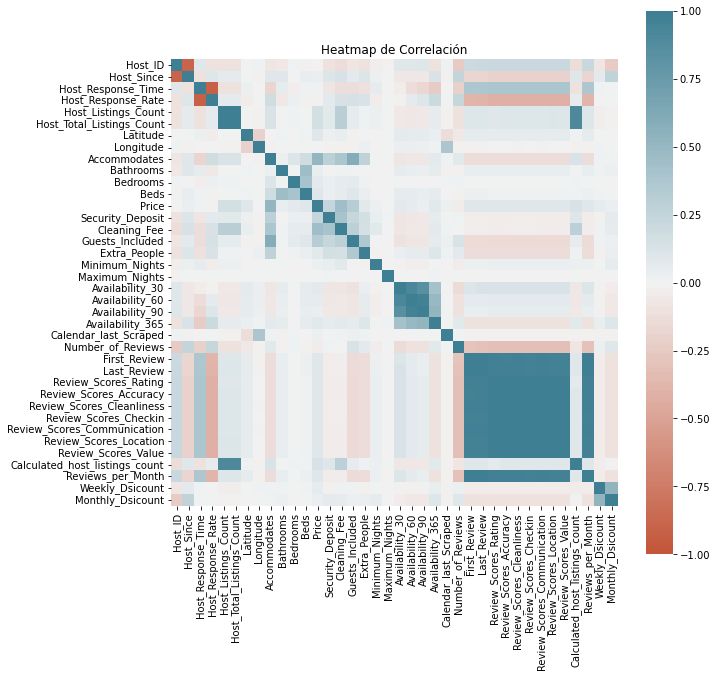

In [ ]:
correlations = data_num.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlations,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
               square=True
)
ax.set(title='Heatmap de Correlación')
plt.show()

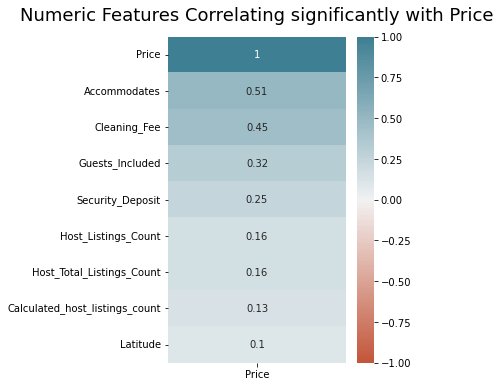

In [ ]:
f, ax = plt.subplots(figsize=(4, 6))
sns.heatmap(
    correlations[['Price']].sort_values(by='Price',ascending=False)[abs(correlations['Price'])>0.1],
    vmin=-1, vmax=1,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True
    );

ax.set_title('Numeric Features Correlating significantly with Price', fontdict={'fontsize':18}, pad=16);

In [ ]:
data_num = pd.get_dummies(data_num)

A continuación vamos a estudiar la variable Neighbourhood_Cleansed. Veremos en qué zonas de Madrid hay más alojamientos de Airbnb disponibles. Para ello, utilizaremos las variables Longitude y Latitude que nos indican en qué zona se encuentra.

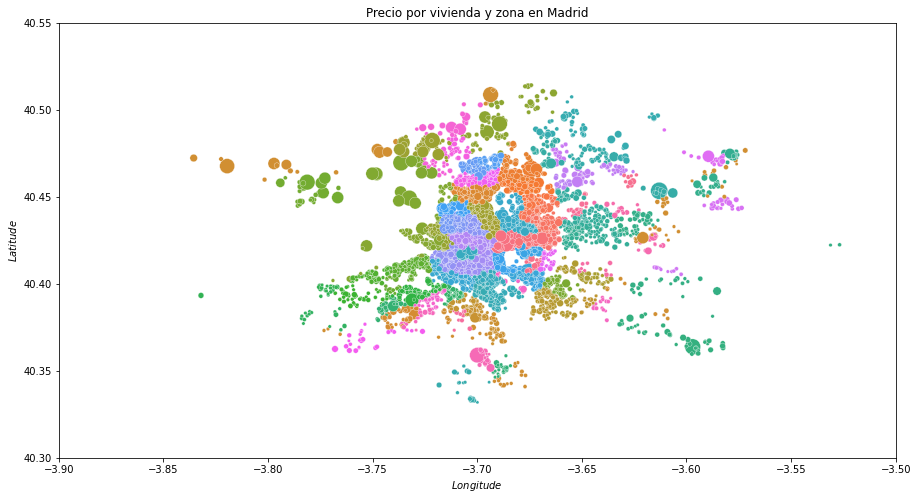

In [ ]:
#Queremos ver que neigbourhood tiene más oferta de Airbnbs 
#- ?le podríamos meter un mapa detras con mplleaflet

fig, ax = plt.subplots(figsize=(15, 8))
with sns.plotting_context("notebook", font_scale=1.5):
    sns.scatterplot(x='Longitude',
                    y='Latitude',
                    size='Price',
                    hue = 'Neighbourhood_Cleansed',
                    palette=sns.color_palette("husl", len(pd.unique(data['Neighbourhood_Cleansed']))),
                    sizes=(10, 300), 
                    data=data, 
                    ax=ax,
                    legend = False)

ax.set_xlabel(r'$Longitude$')
ax.set_ylabel(r'$Latitude$')
ax.set(ylim=(40.3,40.55), xlim=(-3.9,-3.5), title='Precio por vivienda y zona en Madrid')

plt.show()

## Principal Component Analysis (PCA)

A continuación realizaremos un **PCA**. Esto nos ayudará no solo a reducir dimensiones en caso de que sea necesario si no a identificar la presencia de outliers

Es conviniente que normalicemos las variables de esta base de datos para poder trabajar con ellas ya que el cálculo de los componentes principales depende de las unidades de medida empleadas en las variables. Esto se debe a que cada variable está medida en una escala diferente. El problema de las escalas diferentes es que luego el análisis le va a dar mayor peso a las variables que estén en escalas mayores. Para evitar esto, lo que haremos es normalizar las variables manualmente, de manera que tengan media cero y desviación estándar uno, ya que, de lo contrario, las variables con mayor varianza dominarían al resto, aunque en el caso en que las variables estén medidas en las mismas unidades, podemos optar por no estandarizarlas. 

El objetivo final de realizar la normalización es reducir todas las características a una escala común sin distorsionar las diferencias en el rango de los valores. El proceso de PCA consiste en identificar las direcciones donde la sea mayor la varianza. La varianza de una variable se mide en su escala elevada al cuadrado. Si antes de calcular los componentes no se normalizan las las variables, las variables cuya escala sea mayor predominarán. Por ello es recomendable estandarizar siempre los datos. A continuación creamos un nuevo dataset con los datos normalizados:


In [ ]:
data_num_norm = (data_num - data_num.mean())/data_num.std()
data_num_norm.head(5)

,Host_ID,Host_Since,Host_Response_Time,Host_Response_Rate,Host_Listings_Count,Host_Total_Listings_Count,Latitude,Longitude,Accommodates,Bathrooms,...,Bed_Type_Airbed,Bed_Type_Couch,Bed_Type_Futon,Bed_Type_Pull-out Sofa,Bed_Type_Real Bed,Cancellation_Policy_flexible,Cancellation_Policy_moderate,Cancellation_Policy_strict,Cancellation_Policy_super_strict_30,Cancellation_Policy_super_strict_60
40,-0.343929,-0.136671,-0.400766,0.039018,-0.241816,-0.241816,-0.643253,0.423865,-0.594104,0.064964,...,-0.01942,-0.033649,-0.05217,-0.134887,0.150302,1.446353,-0.652679,-0.778404,-0.012281,-0.01942
41,-0.350969,-0.128134,-0.370083,0.499207,-0.313712,-0.313712,0.244734,0.247777,-0.594104,-0.102801,...,-0.01942,-0.033649,-0.05217,-0.134887,0.150302,-0.691342,1.532032,-0.778404,-0.012281,-0.01942
42,0.868699,-0.935734,-0.400766,0.499207,-0.277764,-0.277764,0.359438,0.157593,-0.092129,-0.102801,...,-0.01942,-0.033649,-0.05217,-0.134887,0.150302,1.446353,-0.652679,-0.778404,-0.012281,-0.01942
43,-0.984237,1.314618,-0.400766,0.499207,-0.062076,-0.062076,0.317386,0.180382,-1.096080,-0.102801,...,-0.01942,-0.033649,-0.05217,-0.134887,0.150302,-0.691342,-0.652679,1.284584,-0.012281,-0.01942
44,-0.773648,0.507018,-0.400766,0.499207,-0.277764,-0.277764,0.374384,0.185954,1.413798,-0.102801,...,-0.01942,-0.033649,-0.05217,-0.134887,0.150302,-0.691342,1.532032,-0.778404,-0.012281,-0.01942


El PCA descubre las combinaciones lineales de características que capturan la cantidad más grande de variación. Cada componente principal representa la dirección en que los predictores tienen la mayor varianza. El PCA alinea los componentes principales con los ejes. Con el gráfico PCA podemos comprobar que el primer componente explica la mayor parte de la varianza. Los eigenvectors de una matriz son los vectores que al multiplicarlos por esa matriz, resultan en el mismo vector o en un múltiplo entero del vector. Todos los eigenvectors de una matriz son ortogonales entre ellos, independientemente de las dimensiones que tengan. En el método PCA, cada una de las componentes se corresponde con un eigenvector, y el orden de componente se establece por orden decreciente de eigenvalue. Así pues, la primera componente es el eigenvector con el eigenvalue asociado más alto. Cada componente principal se obtiene por combinación lineal de las variables originales.

El vector que define la primera componente principal (Componente 1) sigue la dirección en la que las observaciones varían más. La proyección de cada observación sobre esa dirección equivale al valor de la primera componente para dicha observación. La segunda componente (Componente 2) sigue la segunda dirección en la que los datos muestran mayor varianza y que no está correlacionada con la primera componente. La condición de no correlación entre componentes principales equivale a decir que sus direcciones son ortogonales.

La función de sklearn .fit_transform() ajusta el modelo creado de PCA, con los datos de entrenamiento, data_num_norm en nuestro caso y aplica la reducción de la dimensionalidad. Es decir, entrena el modelo PCA con los datos de entrada. La función fit_transform() se utiliza en los datos de entrenamiento para que podamos escalar los datos de entrenamiento y también aprender los parámetros de escalado de esos datos. Aquí, el modelo construido por nosotros aprenderá la media y la varianza de las características del conjunto de entrenamiento. Estos parámetros aprendidos se utilizan para escalar nuestros datos de prueba. La diferencia entre fit() y fit_transform() es que el método fit consiste en calcular la media y la varianza de cada una de las características presentes en nuestros datos y el método de fit_transform transforma todas las características utilizando la media y la varianza respectivas.

El método de PCA permite simplificar la información aportada por muchas variables en pocos componentes. Esto lo convierte en un método muy útil de aplicar previa utilización de otras técnicas estadísticas que utilizaremos más adelante como por ejemplo clustering.

Cuando se trabaja con las varianzas, el PCA es muy sensible a los valores atípicos, por lo que es importante estudiar si los hay. En esta sección, también detectaremos los outliers mediante el PCA.


Text(0.5, 1.0, 'PCA')

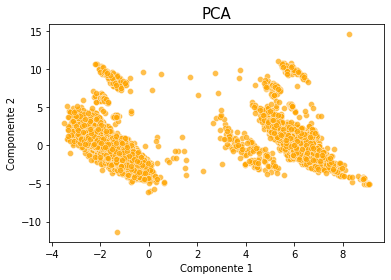

In [ ]:
# Realizamos el primer modelo PCA con todos los componentes

data_num_PCA = data_num_norm.drop(columns ='Price')

pca = PCA(n_components = 176, whiten=False, random_state=random_num)
data_PCA = pca.fit_transform(data_num_PCA)
sns.scatterplot(data_PCA[:,0], data_PCA[:,1],
                color='orange',alpha=0.7)

plt.xlabel("Componente 1", fontsize = 10)
plt.ylabel("Componente 2", fontsize = 10)
plt.title('PCA', fontsize = 15)


In [ ]:
var = np.cumsum(pca.explained_variance_ratio_)
comps = [i for i,el in enumerate(np.cumsum(pca.explained_variance_ratio_)) if el > 0.85][0]
print(comps)

118


Vemos que 119 componentes explican el 85% de la varianza y por tanto será suficiente quedarnos con 119 en lugar de 180. 

In [ ]:
pca = PCA(n_components = comps, whiten=False, random_state=random_num)
data_PCA = pca.fit_transform(data_num_PCA)

In [ ]:
#Variables principales del primer componente

main_variables = sorted([(abs(el),i) for i,el in enumerate(pca.components_[0])], reverse=True)
print(main_variables[:8])
[data_num_norm.columns[i] for n,i in main_variables[:8]]

[(0.2948106615582756, 30), (0.29470325422220756, 28), (0.29457776743804465, 27), (0.29451367186488436, 29), (0.29442008216740656, 31), (0.2944175648447229, 32), (0.2943864649874548, 26), (0.2910424342217889, 25)]


['Review_Scores_Checkin',
 'Review_Scores_Accuracy',
 'Review_Scores_Rating',
 'Review_Scores_Cleanliness',
 'Review_Scores_Communication',
 'Review_Scores_Location',
 'Last_Review',
 'First_Review']

In [ ]:
reverse = pca.inverse_transform(data_PCA)

data_nump = data_num_PCA.to_numpy()

error = (data_num_PCA - reverse)**2

score = np.sum(error,1)
score_mean = np.mean(score)
score_std = np.std(score)
outliers = np.where(score> score_mean + 5*score_std)

Text(0, 0.5, 'Componente 2')

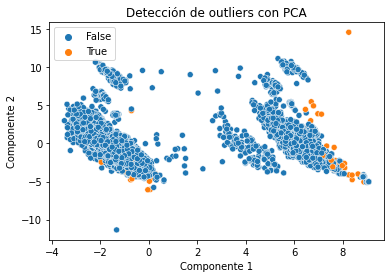

In [ ]:
mark_outlier = np.where(score> score_mean + 5*score_std, True, False)
sns.scatterplot(data_PCA[:,0], data_PCA[:,1], hue=mark_outlier)
plt.title('Detección de outliers con PCA')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')

In [ ]:
sumoutliers=np.sum(mark_outlier)
print("Total de outliers en la base de datos detectados con PCA:", sumoutliers)

Total de outliers en la base de datos detectados con PCA: 63


Hemos obtenido el gráfico PCA con los valores atípicos en color naranja. Para ello, hemos creado una variable llamada mark_outlier donde se generan los outliers y que cuando detecta un outlier indica que es "False" y cuando no lo hay se indica que es "True". Después creamos un diagrama de puntos con sns.scatterplot y insertamos la nueva variable creada mark_outlier dentro de hue para así indicar en un color distinto los outliers y en la leyenda aparezca cuales son los outliers (False). Estos valores atípicos convendría quitarlos o examinarlos ya que podrían afectar nuestro estudio. Podemos observar que hay algún dato que esta alejado y que podría parecer un valor atípico pero lo es y no aparece de otro color porque estamos representando únicamente dos dimensiones, y pueden haber muchas más. Además, algunos datos atípicos podrían estar solapados.

Por hacer: 

    - Host_Verifications --> ?? 
    - Calendar_Updated
    - Clusterización
    - Busqueda de outliers con DBscan
    - Borrar Zipcode


## **Entrnamiento de Modelos**

### Train-Test Split

In [ ]:
data_train, data_test = train_test_split(data_num, test_size = 0.3, random_state = random_num)


In [ ]:
#Normalizamos el conjunto de entrenamiento y test que seran usados si el algoritmo lo requiere
scaler = StandardScaler()
train_scaler = scaler.fit(data_train)

data_train_norm = pd.DataFrame(index=data_train.index,
                               columns=data_train.columns,
                               data=train_scaler.transform(data_train))

data_test_norm = pd.DataFrame(index=data_test.index,
                               columns=data_test.columns,
                               data=train_scaler.transform(data_test)) #normalizamos usando el Scaler de train

In [ ]:
columns = ['pca_comp_%i' % i for i in range(comps)]
df_pca  = pd.DataFrame(data_PCA, columns=columns, index=data_num_PCA.index)

In [ ]:
df_pca['Price'] = data_num['Price']

In [ ]:
data_train_pca, data_test_pca = train_test_split(df_pca, test_size = 0.3, random_state = random_num)

In [ ]:
X_train = data_train.drop(columns='Price')
X_train_norm = data_train_norm.drop(columns='Price')
Y_train = data_train['Price']
Y_train_norm = data_train_norm['Price']

X_test = data_test.drop(columns='Price')
X_test_norm = data_test_norm.drop(columns='Price')
Y_test = data_test['Price']
Y_test_norm = data_test_norm['Price']

X_train_pca = data_train_pca.drop(columns='Price')
Y_train_pca = data_train_pca['Price']
X_test_pca = data_test_pca.drop(columns='Price')
Y_test_pca = data_test_pca['Price']

### Regresión lineal 

mas basica
sirve de liston
no optimizamos para ver capacidad predictiva de mas basic

In [ ]:
lr = LinearRegression()
lr.fit(X_train_norm, Y_train)
lr.score(X_train_norm, Y_train)

0.592358818709285

### Random Forest 

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters_forest = ({'max_depth': [10, 15, 20],
                      'n_estimators': [150, 200, 250]})
forest_grid = RandomForestRegressor()

clf_forest = GridSearchCV(forest_grid, parameters_forest, n_jobs=4, cv=3)
clf_forest.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [10, 15, 20],
                         'n_estimators': [150, 200, 250]})

In [ ]:
clf_forest.best_params_

{'max_depth': 20, 'n_estimators': 250}

In [ ]:
forest = RandomForestRegressor(max_depth = clf_forest.best_params_['max_depth'],
                               n_estimators= clf_forest.best_params_['n_estimators'])
forest.fit(X_train, Y_train)
forest.score(X_train, Y_train)

0.9515325577687759

### XGBOOST

In [ ]:
import xgboost as xgb

parameters_xgb = ({'max_depth': [10, 15, 20],
                    'n_estimators': [150, 200, 250]}) #mismos hiperparametros para que sea comparale
xgb_grid = xgb.XGBRegressor()

clf_xgb = GridSearchCV(xgb_grid, parameters_xgb, n_jobs=4, cv=3)
clf_xgb.fit(X_train, Y_train)

[03:57:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, estimator=XGBRegressor(), n_jobs=4,
             param_grid={'max_depth': [10, 15, 20],
                         'n_estimators': [150, 200, 250]})

In [ ]:
clf_xgb.best_params_

{'max_depth': 10, 'n_estimators': 200}

In [ ]:
xgb = xgb.XGBRegressor(max_depth = clf_xgb.best_params_['max_depth'],
                               n_estimators= clf_xgb.best_params_['n_estimators'])
xgb.fit(X_train, Y_train)
xgb.score(X_train, Y_train)

[03:59:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9904225473883396

### XGBOOST - PCA

In [ ]:
xgb_grid_pca = xgb.XGBRegressor()

clf_xgb_pca = GridSearchCV(xgb_grid_pca, parameters_xgb, n_jobs=4, cv=3)
clf_xgb_pca.fit(X_train_pca, Y_train_pca)

KeyboardInterrupt: ignored

In [ ]:
clf_xgb_pca.best_params_

{'max_depth': 10, 'n_estimators': 200}

In [ ]:
xgb_pca = xgb.XGBRegressor(max_depth = clf_xgb_pca.best_params_['max_depth'],
                               n_estimators= clf_xgb_pca.best_params_['n_estimators'])
xgb_pca.fit(X_train_pca, Y_train_pca)
xgb_pca.score(X_train_pca, Y_train_pca)

[03:59:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.9904225473883396

### Red Neuronal

In [ ]:
import tensorflow as tf

In [ ]:
#with tf.device('/device:GPU:0'):
#Le indicamos cual es el formato de nuestra entrada. Cuantos nodos tiene
inputs = tf.keras.Input(shape=(X_train_norm.shape[1],))

# A partir de aquí vamos enlazando las capas, la salida de una con la entrada de otra
# en la propia definición de las capas podemos decir que función de activación usamos.
# La capa más común, y la que utilizaremos en este ejercicio son las que usa MLP, o Densas
# ya que conectan todos los nodos de entrada con los de salida
x = tf.keras.layers.Dense(254, activation="relu")(inputs) #capa predictiva
x = tf.keras.layers.Dropout(0.2)(x) #capa dropout para evitar overfitting
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)

# Por último, construimos nuestra capa de salida
output = tf.keras.layers.Dense(1)(x)

#Y creamos nuestro modelo completo donde le indicamos las salidas y las entradas.
# Hay que crear un objeto modelo, ya que este es el que nos permite ser entrenado y evaluado.
model = tf.keras.Model(inputs, output)

In [ ]:
model.compile(optimizer='adam', #metodo adam mejor reusltados
              loss=tf.keras.losses.MeanSquaredError(),
             metrics=tf.keras.metrics.RootMeanSquaredError(name='rmse'))

In [ ]:
model.fit(X_train_norm.to_numpy(),
          Y_train.to_numpy(), 
          epochs=100, 
          validation_data=(X_test_norm.to_numpy(),Y_test.to_numpy()),
          )

Epoch 1/100
291/291 [==============================] - 2s 4ms/step - loss: 2944.3000 - rmse: 54.2614 - val_loss: 4246.9565 - val_rmse: 65.1687
Epoch 2/100
291/291 [==============================] - 1s 4ms/step - loss: 1738.7050 - rmse: 41.6978 - val_loss: 2775.5625 - val_rmse: 52.6836
Epoch 3/100
291/291 [==============================] - 1s 3ms/step - loss: 1593.8528 - rmse: 39.9231 - val_loss: 2116.2913 - val_rmse: 46.0032
Epoch 4/100
291/291 [==============================] - 1s 4ms/step - loss: 1531.3077 - rmse: 39.1319 - val_loss: 2434.8022 - val_rmse: 49.3437
Epoch 5/100
291/291 [==============================] - 1s 4ms/step - loss: 1490.9036 - rmse: 38.6122 - val_loss: 2205.7664 - val_rmse: 46.9656
Epoch 6/100
291/291 [==============================] - 1s 4ms/step - loss: 1461.1768 - rmse: 38.2253 - val_loss: 2292.1172 - val_rmse: 47.8761
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 1435.8052 - rmse: 37.8920 - val_loss: 2042.2305 - val_rmse: 45.1910

## **Model Testing**

In [ ]:
from sklearn.metrics import mean_squared_error, mean_poisson_deviance

In [ ]:
rmse_forest = mean_squared_error(y_true = Y_test, y_pred = lr.predict(X_test_norm))
rmse_forest

4.439138916502344e+24

In [ ]:
predicted_forest = forest.predict(X_test)
rmse_forest = mean_squared_error(y_true = Y_test, y_pred = predicted_forest)
rmse_forest

1095.3816484178005

In [ ]:
predicted_xgb = xgb.predict(X_test)
rmse_xgb = mean_squared_error(y_true = Y_test, y_pred = predicted_xgb)
rmse_xgb

1083.3330894257779

In [ ]:
predicted_data_norm = data_test_norm.copy()
predicted_data_norm['Price'] = model.predict(X_test_norm.to_numpy())
predicted_data_unorm = pd.DataFrame(index=predicted_data_norm.index, columns=predicted_data_norm.columns, data=train_scaler.inverse_transform(predicted_data_norm))
predicted_data_unorm['Predicted_Price'] = predicted_data_unorm['Price']
predicted_data_unorm['Price'] = data_test['Price']

rmse_nn = round(np.mean(100*np.sqrt((predicted_data_unorm['Price'] - predicted_data_unorm['Predicted_Price'])**2)/predicted_data_unorm['Price']),2)
rmse_nn

5884.5